# Short GenAI Workshop

In this workshop we will assist the toy manufacturerer "LykkeLand Leketøysfabrikk". Their internal data warehouse is a mess and they want us to help.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pprint import pprint
# from openai import AzureOpenAI
from langfuse.openai import AzureOpenAI
from dotenv import load_dotenv

sys.path.append('..')
load_dotenv()

client = AzureOpenAI(
    # api_version=os.environ["AZURE_OPENAI_API_KEY"],
    # api_key=os.environ["AZURE_OPENAI_ENDPOINT"],
    # api_version=os.environ["OPENAI_API_VERSION"],
)

### Helper functions

In [2]:
from IPython.display import display, Markdown

def get_completion_from_prompt(prompt: str) -> str:
    """
    Function that creates a post against openAI chatGPT service
    in Azure AI from a string prompt and returns the first and
    most deterministic response/completion.

    :param prompt: A string prompt to be sent to the chatGPT service

    :return: A string representation of the first answer proposed by the algorithm
    """
    messages = [{"role": "user", "content": prompt}]

    response = client.chat.completions.create(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],
        messages=messages,
        temperature=0,
    )

    return response.choices[0].message.content


def read_file(path: str) -> str:
    with open(path) as f:
        text = f.read()
    return text.replace("Ã¦", "æ").replace("Ã¥", "å").replace("Ã¸", "ø")


def print_pretty(text: str) -> None:
    display(Markdown(text))

In [3]:
# Verify correct setup
get_completion_from_prompt("Hello")

'Hello! How can I assist you today?'

# Task: Data Cleaning of Product Reviews from Text Data

LykkeLand has gathered a substantial amount of product reviews to assess customer satisfaction. Unfortunately, the data collection process overlooked the inclusion of critical numerical and categorical fields, which is a limiting factor for the quality of analysis available. The dataset comprises usernames, dates, locations, review titles, and the main body of the text, collected from customers in both Norway and abroad. However, it lacks detailed information about the specific products being reviewed. Despite these limitations, there's still potential for meaningful analysis by leveraging language models to impute missing details and categorize the reviews based on the available text.

*Note: This notebook assumes a basic familiarity with the Pandas library.*


## Explore data
The product reviews collected from customers over the past few months are stored in an Excel sheet. Let's take a look

In [4]:
import pandas as pd

df = pd.read_excel("../data/product_reviews.xlsx")
df

,username,date,location,title,body
0,Stjernestøv78,2023-02-01,Mo i Rana,Nattlig Magi Med StjerneSøkeren,Helt siden vi fikk den hjem har det vært stjer...
1,afitloop,2023-02-04,Sharjah,مراجعة لعبة القلعة الخشبية,بصراحة، استفدنا من القلعة الخشبية اللي اشترينا...
2,JazzyJeff75,2023-02-05,Marseille,Ca a vraiment un truc ce RoboRex!,"Alors voila, j'ai acheté le RoboRex pour le fi..."
3,JustineDuJour,2023-02-05,"Marseille, France",Un robot dino trop cool!,"Alors là, franchement, chapeau! J’ai offert le..."
4,Stjernemamma82,2023-02-05,Göteborg,"Underbar stjärnhimmel, men produkten fanns int...",Beställde StjerneSøkeren till min dotter som ä...
...,...,...,...,...,...
58,FuriousMommaBear87,2023-04-15,"Tampa, FL",Absolutely Appalled by the Service!,"okay, so where do i begin? i ordered the Skoge..."
59,AuroraSol,2023-04-17,"Lillehammer, Norge","Søt leke, men litt for dyr",Har akkurat fått Skogeventyrssettet i posten o...
60,FjellEntusiast42,2023-04-18,"Lom, Norge",Artig tid med RoboRex,Kjøpte denne robotdinosaurleken til 5-åringen ...
61,HyperHilda,2023-04-20,Oslo,Sykt kult labsett!,"Ok, må bare si at KrystallVekst Laben min har ..."


Let's take a look at a single review in the sheet:

In [5]:
single_review = df.iloc[-1]

pprint(single_review.to_dict())

{'body': 'So we bought this KrystallVekst Lab toolkit for our daughter since '
         "she's always been into shiny stones and stuff that sparkles. Let me "
         'tell you, it was a hit! We had such a blast mixing the solutions and '
         'watching the crystals form day by day. The result? Some pretty '
         'spectacular crystals - she even managed to convince her little bro '
         "they're real gems! On the downside, I wish the instructions were "
         "clearer. They assume you know a bit about chemistry, but let's be "
         "real, I'm no Marie Curie, haha. Ended up doing a bit of Googling to "
         'get it right, so pro tip - do your homework before starting. Cheers!',
 'date': Timestamp('2023-04-26 00:00:00'),
 'location': 'Gøteborg',
 'title': 'Took bottle rockets to a whole new level!',
 'username': 'StarGazer84'}


## Translating and summarizing reviews
To get a clear picture of what our customers think, we need to translate all reviews into a language we can read. It would also be useful with a dense summary. This way, we can quickly catch their general vibe and pinpoint the exact issues or compliments they're highlighting.

In [6]:
# TODO: Write a prompt which translates the review body into English and summarizes it

def condense_and_translate_review(review: pd.Series) -> str:
    prompt = f"""Please summarize the following review in one English sentence:
Title: <title> {review["title"]} </title>
Review: <review> {review["body"]} </review>    
"""
    return get_completion_from_prompt(prompt)

In [7]:
# Test: check if the function works as expected. The output should be a string
# containing a summary of the review body in English

pprint(condense_and_translate_review(single_review))

('The KrystallVekst Lab toolkit was a huge success for our daughter, allowing '
 'us to create impressive crystals together, though the unclear instructions '
 'required some additional research.')


In [8]:
# Standardize and translate review body for each row in the dataframe
df["standardized_body"] = df.apply(lambda row: condense_and_translate_review(row), axis=1)

In [9]:
df["standardized_body"]

0     The reviewer expresses their love for the Stje...
1     The wooden castle toy we bought for our kids e...
2     The reviewer found the RoboRex to be a fun and...
3     The reviewer highly recommends the RoboRex as ...
4     The reviewer praises the StjerneSøkeren for it...
                            ...                        
58    The reviewer is extremely dissatisfied with Le...
59    The reviewer finds the Skogeventyrssettet char...
60    The RoboRex robot dinosaur toy has been a hit ...
61    The reviewer finds the KrystallVekst Lab excit...
62    The KrystallVekst Lab toolkit was a huge succe...
Name: standardized_body, Length: 63, dtype: object

#### Find trends in the reviews
We can also summarize all the rows to gain an overview of common complaints among customers.

In [10]:
all_review_bodies = "\n\n".join(df["standardized_body"].to_list())

In [11]:
prompt = """Summarize the following reviews:""" # your prompt here
for review in df["standardized_body"]:
    prompt += f"\n\n<review>{review}</review>"
prompt += """Use the following output format:
### Product related feedback
**<product>**: <feedback summary> \n

### Other feedback

### Summary

### Recommendations
<recommendations for what LykkeLand can do to improve the products or customer satisfaction>
"""
# pprint(prompt)
condensed_reviews = get_completion_from_prompt(prompt)


In [12]:
print_pretty(condensed_reviews)

### Product related feedback
**StjerneSøkeren**: The star projector is well-made and captivates children with its clear constellations, although image clarity diminishes in larger rooms and delivery can be delayed.

**Wooden Castle Toy**: Exceeds quality expectations and fosters bonding during assembly, but packaging arrived damaged, affecting the unboxing excitement.

**RoboRex**: Generally fun and durable, delighting children with its interactive features, but concerns include high price, quick battery drain, and some setup confusion.

**Mini Planetarium Projector**: High quality and clear projections create a captivating experience, though delivery was delayed.

**Skogeventyrssettet**: Praised for quality and imaginative play, but some pieces were difficult to assemble, and delivery was slow.

**Fargefantasia Art Set**: Vibrant colors and quality materials excite children, though minor packaging issues were noted.

**KrystallVekst Lab**: Engaging and educational, but delivery delays and minor issues with materials were mentioned.

### Other feedback
The reviews highlight a mix of positive experiences with product quality and educational value, alongside frustrations with delivery delays and customer service. Many reviewers express a desire for clearer instructions and better packaging.

### Summary
Overall, products like RoboRex and StjerneSøkeren are well-received for their engaging features and educational value, while issues with delivery times and packaging detract from the overall experience. Customers appreciate quality but desire improvements in service and product instructions.

### Recommendations
1. **Improve Delivery Times**: Streamline logistics to ensure timely delivery, especially for birthday gifts.
2. **Enhance Packaging**: Ensure packaging is robust to prevent damage during transit.
3. **Provide Clear Instructions**: Include clearer setup and usage instructions for complex toys to enhance user experience.
4. **Consider Battery Inclusion**: Include batteries with toys like RoboRex to enhance immediate usability.
5. **Expand Product Options**: For items like StjerneSøkeren, consider offering more constellation options to increase appeal.

## Inferring country from location

The location data column is less than ideal. Unfortunately, there has been no validation in the form when the customer filled out location. As you see below, sometimes location is written as "city, country", sometimes just "city", sometimes just country and sometimes even "city, state".

In [6]:
print(set(df["location"].to_list()))

{'Lyon', 'Paris, France', 'Siljan', 'Luleå, Sverige', 'Lund, Sverige', 'Gøteborg', 'Skien', 'Lyon, France', 'Molde', 'Örebro, Sverige', 'Houston', 'Trondheim, Norge', 'Montpellier, France', 'Tromsø', 'Houston, TX', '厦门', 'Stockholm, Sweden', 'Stjørdal', 'Lom, Norge', 'Voss', 'Göteborg', 'Gothenburg', 'Haugesund', 'Miami, FL', 'Nancy', 'Tampa, FL', 'Augsburg, Germany', 'Lom', 'Sogndal', 'Oslo', 'Gothenburg, Sverige', 'Toulouse, France', 'Voss, Norge', 'France', 'Lillehammer, Norge', 'Mo i Rana', 'Trondheim', 'Dresden', 'Sharjah', 'Florida, USA', 'Lillehammer', 'Trondheim, Norway', 'Marseille, France', 'Marseille'}


We can use a language model to standardize this information. Let's try to extract the country for each review.

**Note:** A potential problem can be that there are multiple ways to write the same country name, i.e. Norway/Kingdom of Norway/Norge/Noreg etc. If you encounter this issue, how can it be fixed?

Try to minimize the amount of information you give the model. Does it need all of the review information to do this task?

In [7]:
# TODO: write a prompt which classifies the country of the review based on the available unique countries

def get_country(review: pd.Series) -> str:
    prompt = f"""Return the country which this review is from. Just the English country name, nothing else.
    
    Location: {review.location}
    Review title: {review.title}
""" # your prompt here
    country = get_completion_from_prompt(prompt)
    return country

In [8]:
# Test: check if the function works as expected. The output should be a string
# containing the country of the review
get_country(single_review) 

'Sweden'

Now let's create a new column called country where we perform this operation for every row in the dataset:

In [9]:
# Classify the country for each review in the dataframe
df["country"] = df.apply(lambda row: get_country(row), axis=1)

Let's plot the result of the classification

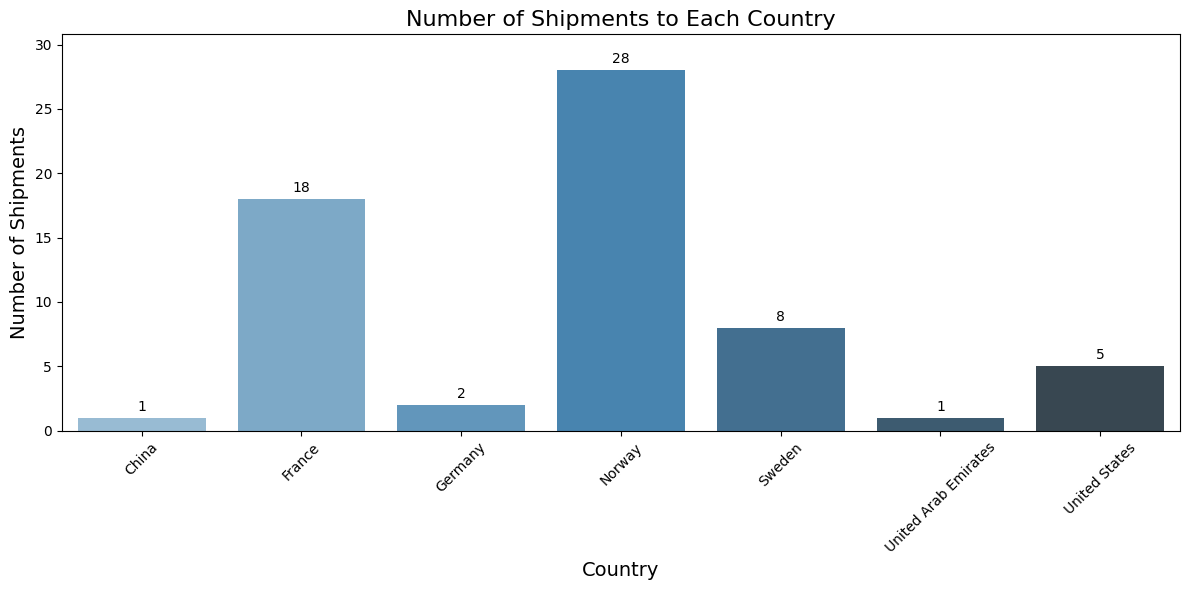

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each country
shipment_counts = df["country"].value_counts().sort_index()

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=shipment_counts.index,
    y=shipment_counts.values,
    hue=shipment_counts.index,
    palette="Blues_d",
    dodge=False,
    legend=False
)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Adjust y-axis limits to add space above the tallest bar
ax.set_ylim(0, shipment_counts.max() * 1.1)  # Increase limit by 10%

# Customize the plot
ax.set_xlabel("Country", fontsize=14)
ax.set_ylabel("Number of Shipments", fontsize=14)
ax.set_title("Number of Shipments to Each Country", fontsize=16)
ax.tick_params(axis="x", rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### Verify if you succeeded

In [12]:
from hackathon.evaluation.country_inferring import verify as verify_country_inferring

verify_country_inferring(df, print_errors=True)

Correctly inferred countries: 63 out of 63
Weeey, you did it! :)


## Rating classification
We aim to quantify a customer's satisfaction level by assigning a numerical score to the review text, for example, ranging from 1 to 5. This process will allow us to systematically evaluate and compare customer feedback, providing a clear metric to gauge overall contentment or dissatisfaction.

In [13]:
# TODO: write a prompt which classifies the rating of each review on a scale from 1 to 5

def get_rating(review: pd.Series) -> int:
    prompt = f"""Rate the following review on a scale from 1 to 5, where 1 is the lowest and 5 is the highest. Output only the number.

<review>{review["body"]}</review>

Guidance:
1: Very negative review
2: Negative review
3: Neutral review. Customer either both liked and disliked the product or was indifferent.
4: Positive review
5: Very positive review
"""
    rating = get_completion_from_prompt(prompt)
    return int(rating)

In [14]:
# Test: check if the function works as expected. The output should be an integer
# containing the rating of the review
get_rating(single_review)

4

In [15]:
# Impute the rating for each review in the dataframe
df["rating"] = df.apply(lambda row: get_rating(row), axis=1)

Let's plot the rating distribution:

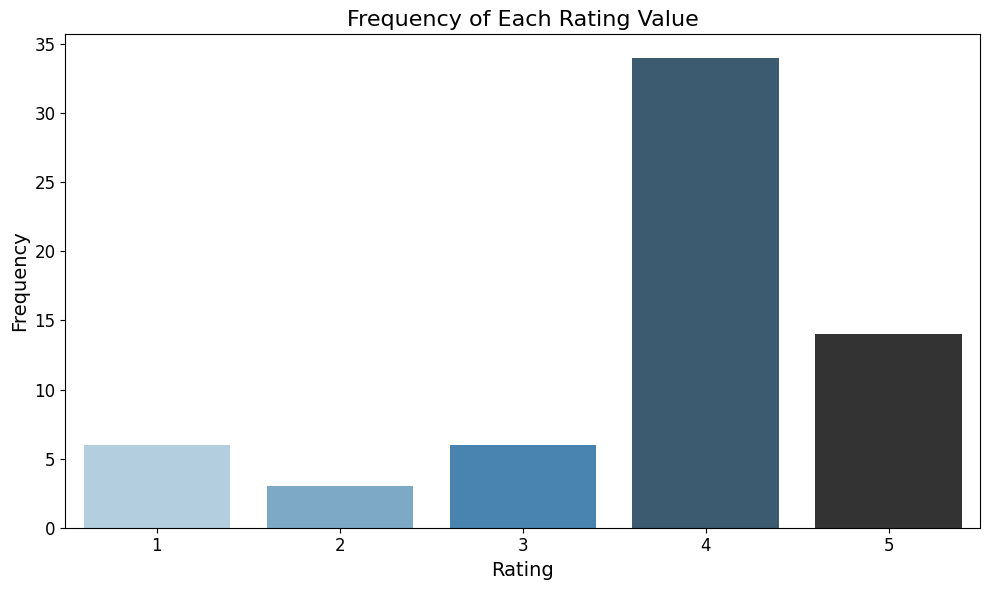

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each rating
rating_counts = df["rating"].value_counts().sort_index()

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=rating_counts.index,
    y=rating_counts.values,
    hue=rating_counts.index,
    palette="Blues_d",
    dodge=False,
    legend=False
)

# Customize the plot
ax.set_xlabel("Rating", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Frequency of Each Rating Value", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

And the average rating by country:

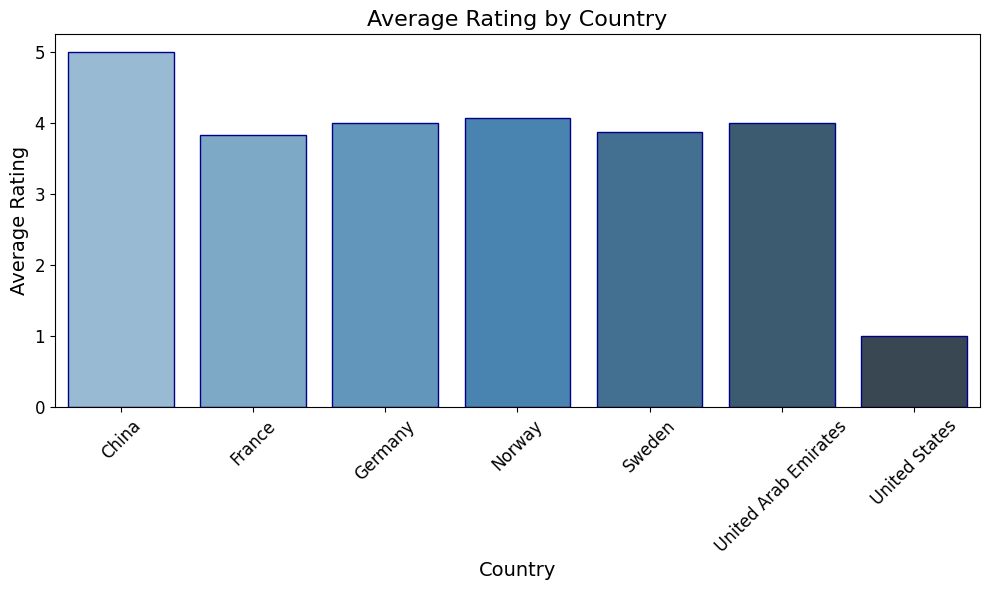

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average rating by country
average_ratings = df.groupby("country")["rating"].mean().sort_index()

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=average_ratings.index,
    y=average_ratings.values,
    hue=average_ratings.index,
    palette="Blues_d",
    edgecolor="darkblue",
    legend=False
)

# Customize the plot
ax.set_xlabel("Country", fontsize=14)
ax.set_ylabel("Average Rating", fontsize=14)
ax.set_title("Average Rating by Country", fontsize=16)
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="both", which="major", labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

#### Verify your analysis

Based on the graph you just plotted. What do you observe? We want you to extract **two** specific insights.

**Note:** Simplify it. Don't consider that there can be errors due to small sample sizes.

In [19]:
from hackathon.evaluation.country_ratings_analysis import evaluate as evaluate_country_ratings_analysis

YOUR_ANSWER = "China has the most satisfied customers, USA has the least."

print(evaluate_country_ratings_analysis(YOUR_ANSWER))

Your answer contains 2 of the 2 desired insights.


## Visualize temporal trends
We can create visual representations to track how ratings from a specific country evolve over time. By plotting these ratings, we can identify patterns, trends, or anomalies, offering valuable insights into how customer satisfaction may vary with different factors or events. This analysis could help in making informed decisions or adjustments in strategy based on temporal shifts in customer feedback.

In [30]:
df["date"] = pd.to_datetime(df["date"])
france_ratings = df[df["country"] == "France"].sort_values("date")

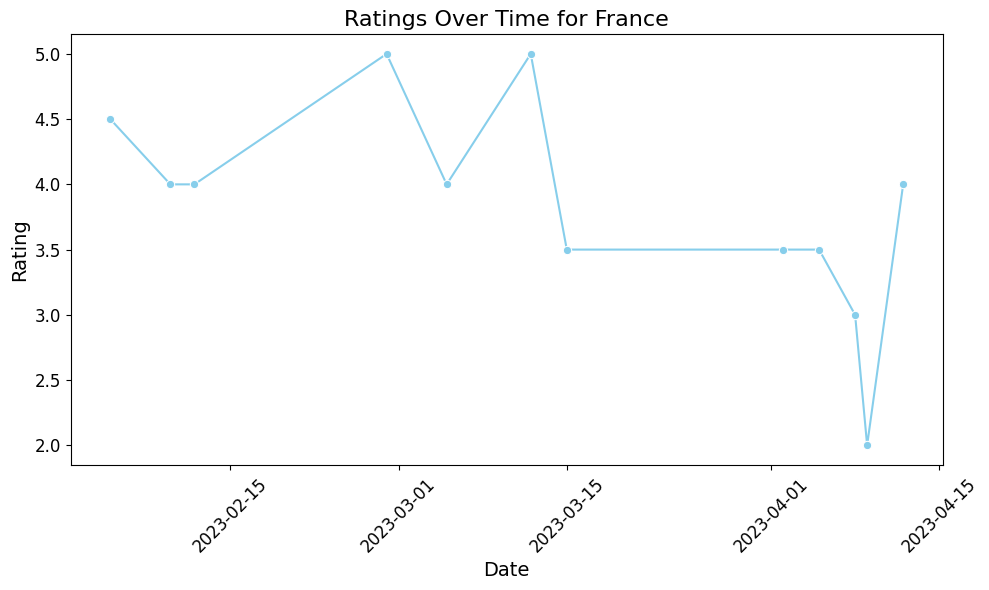

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the line plot using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    x="date",
    y="rating",
    data=france_ratings,
    marker="o",
    color="skyblue",
    errorbar=None
)

# Customize the plot
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Rating", fontsize=14)
ax.set_title("Ratings Over Time for France", fontsize=16)
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="both", which="major", labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

**Task:** Why does it seem like the ratings for France has detoriated after 2023-03-15? Find the answer by analyzing the (relevant) reviews using a LLM.

## Next steps: Experiment and play with the data yourself